In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
from torchvision.transforms import v2
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from typing import cast, Tuple

In [2]:
import spoofdet.config as config
from spoofdet.efficient_net.model_utils import check_dataset_distribution, display_train_result, analyze_spoof_types, analyze_dataset_spoof_distribution, display_params, verify_subject_split, get_data_for_training, get_model, invert_label
from spoofdet.train import train_model
from spoofdet.evaluate import evaluate_model
from spoofdet.data_processing import get_transform_pipeline, create_subset
from spoofdet.utils import check_image, check_augmented_image, save_results
from spoofdet.dataset import CelebASpoofDataset

## params

In [3]:
EPOCHS = 50
EARLY_STOPPING_PATIENCE = 5
TARGET_SIZE = 384
NUM_WORKERS = 2
BATCH_SIZE = config.BATCH_SIZE
TRAIN_IMG_COUNT = 10000
VAL_IMG_COUNT = 4000
TEST_IMG_COUNT = 2000

In [4]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpu_transforms_train, gpu_transforms_val = get_transform_pipeline(device=device, target_size=TARGET_SIZE)

In [6]:
cpu_transform = transforms.Compose([
    # Resize removed - GPU transforms will handle it
    transforms.ToTensor(),  # Only converts PIL Image to tensor [0, 1]
])

train_data = datasets.ImageFolder(
    root=config.REAL_VS_FAKE_PATH / 'train',
    transform=cpu_transform,
    target_transform=invert_label
)

val_data = datasets.ImageFolder(
    root=config.REAL_VS_FAKE_PATH / 'valid',
    transform=cpu_transform,
    target_transform=invert_label
)

test_data = datasets.ImageFolder(
    root=config.REAL_VS_FAKE_PATH / 'test',
    transform=cpu_transform,
    target_transform=invert_label
)

In [7]:
train_idx = torch.randperm(len(train_data))[:TRAIN_IMG_COUNT].tolist()
val_idx = torch.randperm(len(val_data))[:VAL_IMG_COUNT].tolist()
test_idx = torch.randperm(len(test_data))[:TEST_IMG_COUNT].tolist()
train_sub_data = Subset(train_data, train_idx)
val_sub_data = Subset(val_data, val_idx)
test_sub_data = Subset(test_data, test_idx)

In [8]:
train_loader = DataLoader(train_sub_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=NUM_WORKERS, 
                          pin_memory=True,
                          persistent_workers=True,
                          drop_last=True)
val_loader = DataLoader(val_sub_data, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False, 
                        num_workers=NUM_WORKERS, 
                        pin_memory=True,
                        persistent_workers=True,
                        drop_last=True)
test_loader = DataLoader(test_sub_data, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False, 
                         num_workers=NUM_WORKERS, 
                         pin_memory=True,
                         persistent_workers=True,
                         drop_last=True)

In [9]:
img, label = train_data[0] 

print(f"Label after transform: {label}")

Label after transform: 1


In [10]:
model_path = "train_results/train_15/model.pt"


In [11]:
model = models.efficientnet_v2_s(weights=None)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(cast(int, in_features), 2)
model.load_state_dict(torch.load(model_path))
model = model.to(device)

In [12]:
# Verify the checkpoint loaded correctly
checkpoint = torch.load(model_path)
print(f"Checkpoint keys: {list(checkpoint.keys())[:5]}...")  # Show first 5 keys
print(f"Classifier weight shape in checkpoint: {checkpoint['classifier.1.weight'].shape}")
print(f"Classifier bias shape in checkpoint: {checkpoint['classifier.1.bias'].shape}")

# Check a sample weight value before loading
print(f"\nBefore loading - sample classifier weight: {model.classifier[1].weight[0, 0].item()}")

Checkpoint keys: ['features.0.0.weight', 'features.0.1.weight', 'features.0.1.bias', 'features.0.1.running_mean', 'features.0.1.running_var']...
Classifier weight shape in checkpoint: torch.Size([2, 1280])
Classifier bias shape in checkpoint: torch.Size([2])

Before loading - sample classifier weight: 0.06588735431432724


In [13]:
# Now actually load the model and verify
model.load_state_dict(checkpoint)
model = model.to(device)

# Check the same weight after loading - should be different!
print(f"\nAfter loading - sample classifier weight: {model.classifier[1].weight[0, 0].item()}")
print(f"Sample feature weight: {list(model.features[0][0].weight.flatten()[:3])}")

# Check if weights actually changed
print("\n✓ Weights loaded successfully!" if model.classifier[1].weight[0, 0].item() != 0 else "⚠ Warning: weights might not be loaded")


After loading - sample classifier weight: 0.06588735431432724
Sample feature weight: [tensor(-0.5440, device='cuda:0', grad_fn=<UnbindBackward0>), tensor(-0.0372, device='cuda:0', grad_fn=<UnbindBackward0>), tensor(0.6311, device='cuda:0', grad_fn=<UnbindBackward0>)]

✓ Weights loaded successfully!


In [14]:
# Quick sanity check - run a forward pass before training
model.eval()
with torch.no_grad():
    sample_batch = next(iter(val_loader))
    images, labels = sample_batch
    images = images.to(device)
    images = gpu_transforms_val(images)
    outputs = model(images)
    loss = criterion(outputs, labels.to(device))
    print(f"\nPre-training validation loss on one batch: {loss.item():.4f}")
    print(f"Sample output logits: {outputs[0].cpu()}")
    print(f"Sample softmax probs: {torch.softmax(outputs[0], dim=0).cpu()}")
model.train()


Pre-training validation loss on one batch: 4.6560
Sample output logits: tensor([ 4.2781, -4.3133])
Sample softmax probs: tensor([9.9981e-01, 1.8566e-04])


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [15]:
print("Type:", type(model.classifier))
print("Value:", model.classifier)

Type: <class 'torch.nn.modules.container.Sequential'>
Value: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)


In [16]:

assert isinstance(model.classifier, nn.Module), "Error: model.classifier is not a Module!"
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [17]:

assert isinstance(model.classifier, nn.Module), "Error: model.classifier is not a Module!"
optimizer = torch.optim.AdamW(params=model.classifier.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

print(f'Using device: {device}')

Using device: cuda


## train loop


In [18]:
model, history = train_model(
    model=model,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    profiler_log_name='fine_tune_efficient_net_profiler',
    train_transforms=gpu_transforms_train,
    val_transforms=gpu_transforms_val,
    early_stopping_limit=EARLY_STOPPING_PATIENCE
)

Epoch [1/50] |Time: 1m 1s Train Loss: 1.2506 |Val Loss: 1.0013 | Val Precision: 48.51% | Val Accuracy: 48.90% | Val Recall: 46.80% | Val F1: 47.64%
Scheduler Step! New LR: 0.00009990  -> New best model saved!
Epoch [2/50] |Time: 0m 49s Train Loss: 0.8924 |Val Loss: 0.7368 | Val Precision: 59.01% | Val Accuracy: 60.47% | Val Recall: 66.94% | Val F1: 62.72%
Scheduler Step! New LR: 0.00009961  -> New best model saved!
Epoch [3/50] |Time: 0m 49s Train Loss: 0.6996 |Val Loss: 0.6088 | Val Precision: 66.57% | Val Accuracy: 69.95% | Val Recall: 79.37% | Val F1: 72.41%
Scheduler Step! New LR: 0.00009912  -> New best model saved!
Epoch [4/50] |Time: 0m 54s Train Loss: 0.6062 |Val Loss: 0.5502 | Val Precision: 70.80% | Val Accuracy: 75.05% | Val Recall: 84.70% | Val F1: 77.13%
Scheduler Step! New LR: 0.00009844  -> New best model saved!
Epoch [5/50] |Time: 0m 50s Train Loss: 0.5619 |Val Loss: 0.5163 | Val Precision: 74.01% | Val Accuracy: 77.85% | Val Recall: 85.41% | Val F1: 79.30%
Scheduler St

D:\JoshFile\Github\spoofing-recognition\src\spoofdet\efficient_net\model_utils.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_loss.show()
D:\JoshFile\Github\spoofing-recognition\src\spoofdet\efficient_net\model_utils.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_precision.show()


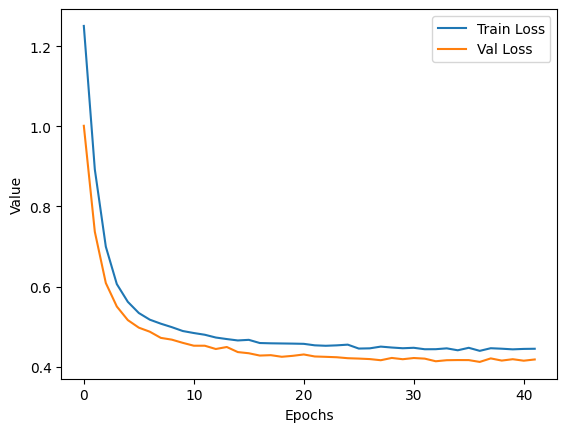

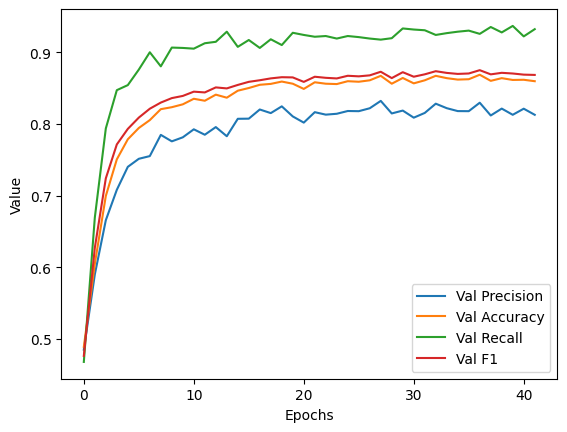

In [19]:
train_loss_fig, precision_fig = display_train_result(history)


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live           830     |        189
Spoof           75     |        890


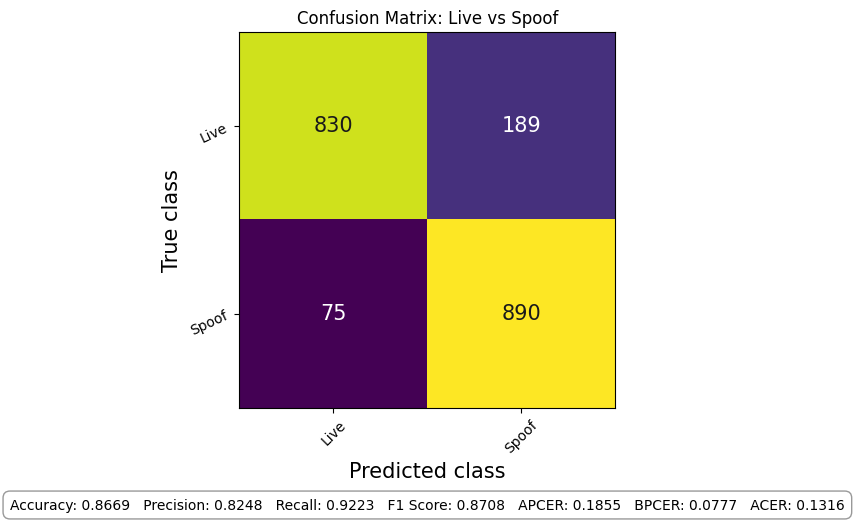

Accuracy: 0.8669
Precision: 0.8248
Recall:    0.9223
F1 Score:  0.8708
Spoofing Metrics: APCER: 0.1855, BPCER: 0.0777, ACER: 0.1316


In [20]:
confusion_matrix, accuracy, precision, recall, f1, spoof_metric_val  = evaluate_model(model=model, dataloader=test_loader, device=device, val_transforms=gpu_transforms_val)


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live           934     |         85
Spoof          204     |        761


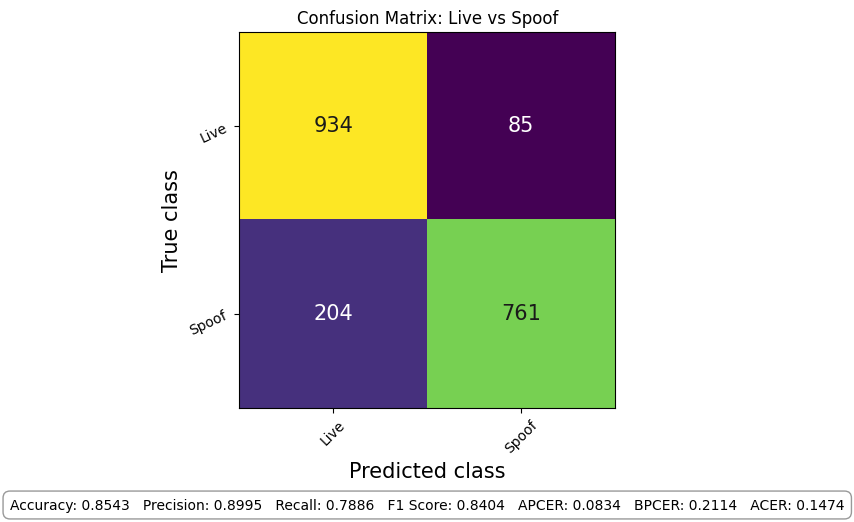

Accuracy: 0.8543
Precision: 0.8995
Recall:    0.7886
F1 Score:  0.8404
Spoofing Metrics: APCER: 0.0834, BPCER: 0.2114, ACER: 0.1474


In [21]:
confusion_matrix, accuracy, precision, recall, f1, spoof_metric_val  = evaluate_model(model=model, dataloader=test_loader, device=device, val_transforms=gpu_transforms_val, threshold=0.582, final_activation="sigmoid")


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live           884     |        135
Spoof          124     |        841


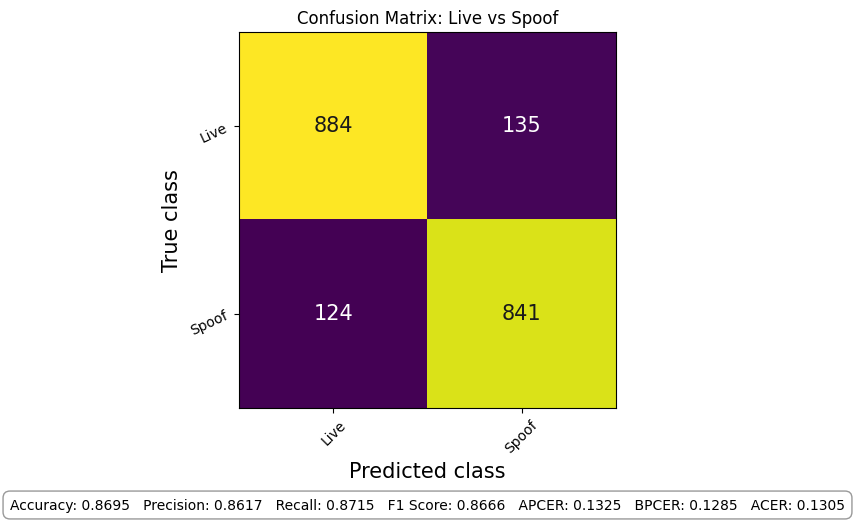

Accuracy: 0.8695
Precision: 0.8617
Recall:    0.8715
F1 Score:  0.8666
Spoofing Metrics: APCER: 0.1325, BPCER: 0.1285, ACER: 0.1305


In [22]:
confusion_matrix, accuracy, precision, recall, f1, spoof_metric_val  = evaluate_model(model=model, dataloader=test_loader, device=device, val_transforms=gpu_transforms_val, threshold=0.582, final_activation="softmax")

In [23]:
save_results(
    model=model,
    confusion_matrix_fig=confusion_matrix,
    train_loss_fig=train_loss_fig,
    precision_fig=precision_fig,
    params={
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "early_stopping_patience": EARLY_STOPPING_PATIENCE,
        "target_size": TARGET_SIZE,
        "optimizer": "AdamW",
        "learning_rate": 1e-4,
        "weight_decay": 1e-5,
        "criterion": "CrossEntropyLoss with label smoothing 0.1"
    },
    spoof_fig=None,
    save_path="fine_tune_results"
)

Saving results to: fine_tune_results\train_2
